# NVIDIA Nemotron Nano 2 VL on Fireworks AI

This notebook demonstrates how to use NVIDIA Nemotron Nano 2 VL, a powerful 12B multimodal reasoning model for document intelligence and product catalog cleansing deployed on Fireworks AI.


## Table of Contents

1. Introduction to NVIDIA Nemotron Nano 2 VL
2. Setting Up Deployment on Fireworks AI
3. Using NVIDIA Nemotron Nano 2 VL for Document Intelligence and OCR

## 1. Introduction to NVIDIA Nemotron Nano 2 VL

### Overview

NVIDIA Nemotron Nano 2 VL is an open 12B multimodal reasoning model for document intelligence and image analysis. Built on a hybrid transformer-Mamba architecture, it combines the best of both worlds:

- **Accuracy on par with transformer-only models**
- **Limited memory and compute usage from Mamba architecture**
- **Higher token throughput and lower latency**

### Key Features

#### High Accuracy
- Trained with NVIDIA curated high-quality synthetic data
- Best-in-class accuracy for:
  - Character recognition (OCR)
  - Chart reasoning
  - Image understanding
  - Video understanding
  - Document intelligence
- **73.2 average score** vs 64.2 with current top VL model on benchmarks including MMMU, MathVista, AI2D, OCRBench, OCRBench-v2, OCR-Reasoning, ChartQA, DocVQA, and Video-MME


### Use Cases

1. **Document Intelligence**
   - IT, finance, insurance, healthcare forms

2. **Content Ingestion**
   - Product catalog cleansing
   - Dense captioning of images/videos

3. **Multi-modal Applications**
   - RAG systems with complex documents, figures, graphs, etc
   - Agentic apps and services

## 2. Setting up on demand deployment on Fireworks AI

### Prerequisites

Before getting started, you'll need:
- A Fireworks AI account ([sign up here](https://fireworks.ai))
- API key from Fireworks AI dashboard ([get one here](https://app.fireworks.ai/settings/users/api-keys))
- Python 3.8 or higher

### Installation

Install the required packages:

In [1]:
! uv pip install -r ../requirements.txt

Using Python 3.12.10 environment at: /Users/robertobarroso/Desktop/repos/cookbook/learn/vlm/.venv
Audited 6 packages in 104ms


### Environment Setup

Set up your Fireworks AI API key:

In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import base64
import requests
from pydantic import BaseModel, Field
from datasets import load_dataset, disable_progress_bars
import json
import pandas as pd
from IPython.display import display
import ast
import re
from typing import List, Dict, Any, Optional, Callable
from enum import Enum
from PIL import Image
from io import BytesIO
from typing import Union
from datetime import datetime

disable_progress_bars()

load_dotenv()

FIREWORKS_API_KEY = os.getenv('FIREWORKS_API_KEY')

if not FIREWORKS_API_KEY:
    raise ValueError("Please set FIREWORKS_API_KEY environment variable")

### Create on-demand deployment for NVIDIA Nemotron Nano 2 VL

Creating an [on-demand deployment](https://fireworks.ai/docs/getting-started/ondemand-quickstart#on-demand-quickstart) for proper testing and benchmarks

In [ ]:
! firectl signin

In [ ]:
! firectl-admin create deployment -a <YOUR-ACCOUNT-ID-HERE> accounts/fireworks/models/nemotron-nano-v2-12b-vl

In [3]:
MAX_TOKENS = 10000
TEMPERATURE = 0.0
MODEL_NAME = "accounts/fireworks/models/nemotron-nano-v2-12b-vl#accounts/pyroworks/deployments/dg6eettw"

### Helper Functions

Utility functions for encoding images and making API calls:

In [4]:
client = OpenAI(
    api_key=FIREWORKS_API_KEY or os.getenv("FIREWORKS_API_KEY"),
    base_url="https://api.fireworks.ai/inference/v1",
)

def encode_image_to_base64(image_path: str) -> str:
    """
    Encode an image file to base64 string.

    Args:
        image_path: Path to the image file

    Returns:
        Base64 encoded string of the image
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def encode_pil_image_to_base64(pil_image: Image.Image) -> str:
    """
    Encode a PIL Image to base64 string.

    Args:
        pil_image: PIL Image object

    Returns:
        Base64 encoded string of the image
    """
    if pil_image.mode not in ('RGB', 'L'):
        pil_image = pil_image.convert('RGB')

    buffer = BytesIO()
    pil_image.save(buffer, format='JPEG')
    buffer.seek(0)

    return base64.b64encode(buffer.read()).decode('utf-8')

def encode_image_url(image_url: str) -> str:
    """
    Download and encode an image from a URL.

    Args:
        image_url: URL of the image

    Returns:
        Base64 encoded string of the image
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    response = requests.get(image_url, headers=headers, timeout=30)
    response.raise_for_status()

    try:
        image = Image.open(BytesIO(response.content))

        if image.mode not in ('RGB', 'L'):
            image = image.convert('RGB')

        buffer = BytesIO()
        image.save(buffer, format='JPEG')
        buffer.seek(0)

        return base64.b64encode(buffer.read()).decode('utf-8')
    except Exception as e:
        raise ValueError(f"Failed to process image from URL: {str(e)}")


def analyze_image(
        image_source: Union[str, Image.Image],
        prompt: str,
        structured_schema=None,
        is_url: bool = False,
        max_tokens: int = MAX_TOKENS,
        temperature: float = TEMPERATURE
):
    """
    Analyze an image using the VLM model.

    Args:
        image_source: Path to image file, URL, or PIL Image object
        prompt: Text prompt for the model
        structured_schema: Structured schema for the response based on Pydantic class
        is_url: Whether image_source is a URL (ignored if PIL Image provided)
        max_tokens: Maximum tokens in response

    Returns:
        Model response (parsed object if structured_schema provided, else string)
    """
    # Determine image type and encode appropriately
    if isinstance(image_source, Image.Image):
        image_b64 = encode_pil_image_to_base64(image_source)
    elif is_url:
        image_b64 = encode_image_url(image_source)
    else:
        image_b64 = encode_image_to_base64(image_source)

    # Build message structure
    messages = [{
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}
            },
        ],
    }]

    # Call appropriate API method based on structured output requirement
    if structured_schema:
        response = client.chat.completions.parse(
            model=MODEL_NAME,
            messages=messages,
            max_tokens=max_tokens,
            response_format=structured_schema,
            temperature=temperature
        )
        return response.choices[0].message.parsed
    else:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature
        )
        return response.choices[0].message.content

### Basic Usage Example

Quick example to verify the setup works:

In [5]:
# Example with a URL image
test_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"

result = analyze_image(
    image_source=test_image_url,
    prompt="Describe this image in a 2-3 sentences.",
    is_url=True
)

print("Model Response:\n")
print(result)

Model Response:

The image depicts a serene landscape with a wooden boardwalk cutting through a lush, green field. The boardwalk, made of weathered wooden planks, stretches into the distance, inviting exploration. The field is filled with tall, vibrant green grass, and the sky above is a clear blue with a few scattered clouds. The overall scene is peaceful and idyllic, evoking a sense of tranquility and natural beauty.



## 3. Use Cases: Document Intelligence

Nemotron Nano 2 VL excels at understanding complex documents including:
- Forms and invoices (see snippets below for examples)
- Screenshots and dashboards
- Healthcare and insurance documents
- Financial reports

Let's explore document intelligence capabilities:

#### OCR and Text Extraction

Extract text from invoices with high accuracy:

Loading 20 image samples...
Successfully loaded 20 samples

DataFrame shape: (20, 5)
Columns: ['image', 'invoice_date', 'invoice_no', 'items', 'summary']

First row preview:
  Invoice No: 40378170
  Invoice Date: 10/15/2012
  Number of items: 1
  Summary of purchase: {'total_net_worth': '$7,50', 'total_vat': '$0,75', 'total_gross_worth': '$8,25'} 

Invoice Example:


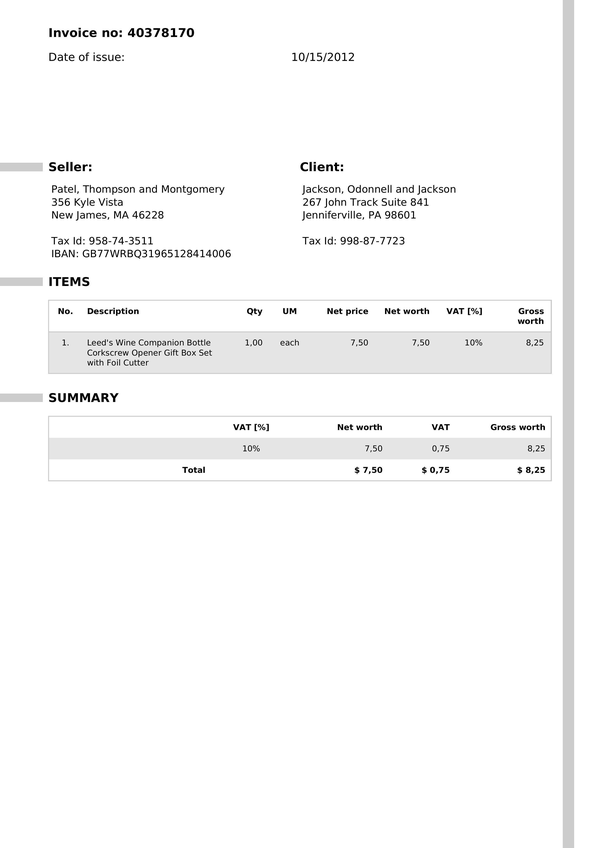

In [23]:
IMAGE_SAMPLE_SIZE = 20

def extract_invoice_data(sample: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    Extract relevant invoice fields from a dataset sample.

    Args:
        sample: Raw sample from the HuggingFace dataset

    Returns:
        Dictionary with extracted fields, or None if parsing fails
    """
    try:
        parsed_data = json.loads(sample['parsed_data'])
        structured_json = ast.literal_eval(parsed_data['json'])
        header = structured_json.get('header', {})

        return {
            'image': sample['image'],
            'invoice_date': header.get('invoice_date'),
            'invoice_no': header.get('invoice_no'),
            'items': structured_json.get('items', []),
            'summary': structured_json.get('summary', {})
        }
    except (json.JSONDecodeError, KeyError, TypeError, ValueError, SyntaxError) as e:
        print(f"Warning: Failed to parse sample {sample.get('id', 'unknown')}: {type(e).__name__}: {e}")
        return None

def load_dataset_from_hf(dataset_name: str, func_extract: Callable, n_samples: int = 5) -> pd.DataFrame:
    """
    Load invoice samples from HuggingFace dataset and convert to DataFrame.

    Args:
        dataset_name: Name of the HuggingFace dataset
        n_samples: Number of samples to load

    Returns:
        DataFrame with columns: image, invoice_date, invoice_no, items, summary
    """
    print(f"Loading {n_samples} image samples...")

    # Load dataset in streaming mode
    ds = load_dataset(dataset_name, split="train", streaming=True)

    samples = []
    for i, sample in enumerate(ds):
        if i >= n_samples:
            break

        extracted = func_extract(sample)
        if extracted:
            samples.append(extracted)

    if not samples:
        raise ValueError(f"Failed to parse any samples. Check error messages above.")

    print(f"Successfully loaded {len(samples)} samples\n")

    df = pd.DataFrame(samples)

    return df

def resize_image_for_display(image: Image.Image, max_width: int = 600) -> Image.Image:
    """
    Resize image maintaining aspect ratio.

    Args:
        image: PIL Image object
        max_width: Maximum width in pixels

    Returns:
        Resized PIL Image
    """
    if image.width <= max_width:
        return image

    aspect_ratio = image.height / image.width
    new_height = int(max_width * aspect_ratio)

    return image.resize((max_width, new_height), Image.Resampling.LANCZOS)

df_invoices = load_dataset_from_hf(
    dataset_name="mychen76/invoices-and-receipts_ocr_v1",
    func_extract=extract_invoice_data,
    n_samples=IMAGE_SAMPLE_SIZE
)

print(f"DataFrame shape: {df_invoices.shape}")
print(f"Columns: {df_invoices.columns.tolist()}")


print(f"\nFirst row preview:")
print(f"  Invoice No: {df_invoices.iloc[0]['invoice_no']}")
print(f"  Invoice Date: {df_invoices.iloc[0]['invoice_date']}")
print(f"  Number of items: {len(df_invoices.iloc[0]['items'])}")
print(f"  Summary of purchase: {df_invoices.iloc[0]["summary"]} ")

print("\n" + "="*80)
print("Invoice Example:")
print("="*80)
_first_image = resize_image_for_display(df_invoices.iloc[0]['image'], max_width=600)
display(_first_image)

Use pydantic classes to set structured output for invoice data extraction

In [24]:
class InvoiceItem(BaseModel):
    """Individual line item on an invoice"""
    description: str = Field(description="Description of the item or service")
    quantity: str = Field(description="Quantity ordered")
    unit_price: str = Field(description="Price per unit")
    net_worth: str = Field(description="Total price before tax")
    vat_rate: Optional[str] = Field(default=None, description="VAT/tax rate percentage")
    gross_worth: str = Field(description="Total price including tax")

class InvoiceData(BaseModel):
    """Structured invoice data extraction"""
    invoice_no: str = Field(description="Invoice number or ID")
    invoice_date: str = Field(description="Invoice date in original format")
    items: List[InvoiceItem] = Field(description="List of items on the invoice")
    total_gross_worth: str = Field(description="Total amount including all taxes")


In [25]:
INVOICE_PROMPT = """
        Extract the following information from this invoice with precise formatting:

        **Invoice Number**: Extract as plain text/numbers only (e.g., "27301261", "INV-2024-001")

        **Invoice Date**: Extract in MM/DD/YYYY format only (e.g., "03/15/2024", "12/01/2023")
        - If date is in other formats, convert to MM/DD/YYYY
        - Use two digits for month and day, four digits for year

        **Line Items**: For each item extract:
        - Description: Full product/service description as written
        - Quantity: Numeric value only as decimal (e.g., 5.00, 2.50, 1.00)
          * Remove any text like "units", "pcs", "ea"
          * Convert commas to decimals: "5,00" becomes "5.00"
        - Gross Worth: Numeric value only as decimal (e.g., 247.50, 1485.00, 8.25)
          * Remove currency symbols ($, €, £)
          * Remove spaces and thousands separators
          * Use period as decimal separator
          * Format: 0.00 (always two decimal places)

        **Total Gross Worth**: Final invoice total as numeric decimal only
        - Format: 0.00 (e.g., 544.46, 57483.07, 176.00)
        - Remove currency symbols, spaces, and separators
        - Use period as decimal separator
        - Must match sum of all line items

        **Critical Rules**:
        1. Numbers: Always use period (.) for decimals, never comma (,)
        2. Currency: Strip all currency symbols and output numbers only
        3. Quantities: Must be valid decimal numbers (e.g., 5.00 not "5,00" or "/gross worth")
        4. Dates: Always MM/DD/YYYY format
        5. If a field is unclear or missing, use null/empty rather than placeholder text

        **Example Output Format**:
        - Invoice Number: "27301261"
        - Invoice Date: "10/09/2012"
        - Line Item: Description="Product ABC", Quantity=5.00, Gross Worth=247.50
        - Total Gross Worth: 544.46
"""

def normalize_currency(value: str) -> Optional[float]:
    """
    Normalize currency string to float for comparison.
    Handles various formats: $8,25 | 8,25 | $ 544,46 | 57 483,07

    Args:
        value: Currency string in various formats

    Returns:
        Float value or None if parsing fails
    """
    if not value:
        return None

    try:
        cleaned = re.sub(r'[$€£¥\s{}]', '', str(value))

        if ',' in cleaned:
            parts = cleaned.split(',')
            if len(parts) == 2 and len(parts[1]) == 2:
                cleaned = parts[0].replace('.', '').replace(' ', '') + '.' + parts[1]
            else:
                cleaned = cleaned.replace(',', '')

        return float(cleaned)
    except (ValueError, AttributeError) as e:
        print(f"Warning: Could not parse currency '{value}': {e}")
        return None

def normalize_date(date_str: str) -> Optional[str]:
    """Normalize various date formats to YYYY-MM-DD"""
    formats = ['%m/%d/%Y', '%Y-%m-%d', '%d/%m/%Y']
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
    return None

def compare_invoice_extraction(df: pd.DataFrame, model_name: str = MODEL_NAME) -> List[Dict[str, Any]]:
    """
    Extract invoice data from all images and compare with ground truth.

    Args:
        df: DataFrame with invoice images and ground truth data
        model_name: Name of the model being used

    Returns:
        List of comparison results
    """

    results = []

    print(f"Analyzing {len(df)} invoices with {model_name}...")
    print("="*100)

    for idx, row in df.iterrows():
        print(f"\n{'='*100}")
        print(f"INVOICE {idx + 1}/{len(df)}")
        print(f"{'='*100}")

        # Extract using model
        try:
            extracted = analyze_image(
                image_source=row['image'],
                prompt=INVOICE_PROMPT,
                structured_schema=InvoiceData
            )

            # Ground truth values
            gt_invoice_no = row['invoice_no']
            gt_date = normalize_date(row['invoice_date'])
            gt_total = row['summary']['total_gross_worth']
            gt_items = row['items']

            # Extracted values
            ex_invoice_no = extracted.invoice_no
            ex_date = normalize_date(extracted.invoice_date)
            ex_total = extracted.total_gross_worth
            ex_items = extracted.items

            # Normalize currency values for comparison
            gt_total_float = normalize_currency(gt_total)
            ex_total_float = normalize_currency(ex_total)

            # Calculate matches
            invoice_match = gt_invoice_no == ex_invoice_no
            date_match = gt_date == ex_date

            # Compare currency with tolerance for floating point precision
            if gt_total_float is not None and ex_total_float is not None:
                total_match = abs(gt_total_float - ex_total_float) < 0.01
            else:
                total_match = False

            item_count_match = len(gt_items) == len(ex_items)

            # Print comparison
            print(f"\n{'Field':<20} {'Ground Truth':<25} {'Extracted':<25} {'Match'}")
            print(f"{'-'*20} {'-'*25} {'-'*25} {'-'*5}")
            print(f"{'Invoice No':<20} {gt_invoice_no:<25} {ex_invoice_no:<25} {'✓' if invoice_match else '✗'}")
            print(f"{'Date':<20} {gt_date:<25} {ex_date:<25} {'✓' if date_match else '✗'}")
            print(f"{'Total (raw)':<20} {gt_total:<25} {ex_total:<25} {'✓' if total_match else '✗'}")
            print(f"{'Total (float)':<20} {f'{gt_total_float:.2f}' if gt_total_float else 'N/A':<25} {f'{ex_total_float:.2f}' if ex_total_float else 'N/A':<25} {'✓' if total_match else '✗'}")
            print(f"{'Item Count':<20} {len(gt_items):<25} {len(ex_items):<25} {'✓' if item_count_match else '✗'}")

            # Print item details
            print(f"\nLine Items:")
            print(f"  Ground Truth: {len(gt_items)} items")
            for i, item in enumerate(gt_items, 1):
                print(f"    {i}. {item['item_desc'][:60]}... | Qty: {item['item_qty']} | Total: {item['item_gross_worth']}")

            print(f"\n  Extracted: {len(ex_items)} items")
            for i, item in enumerate(ex_items, 1):
                print(f"    {i}. {item.description[:60]}... | Qty: {item.quantity} | Total: {item.gross_worth}")

            results.append({
                'index': idx,
                'invoice_no_match': invoice_match,
                'date_match': date_match,
                'total_match': total_match,
                'item_count_match': item_count_match,
                'ground_truth': {
                    'invoice_no': gt_invoice_no,
                    'date': gt_date,
                    'total_raw': gt_total,
                    'total_float': gt_total_float,
                    'item_count': len(gt_items)
                },
                'extracted': {
                    'invoice_no': ex_invoice_no,
                    'date': ex_date,
                    'total_raw': ex_total,
                    'total_float': ex_total_float,
                    'item_count': len(ex_items)
                }
            })

        except Exception as e:
            print(f"\n❌ ERROR: Failed to process invoice {idx + 1}")
            print(f"   Error: {str(e)}")
            results.append({
                'index': idx,
                'error': str(e)
            })

    return results


In [26]:
# Run comparison
comparison_results = compare_invoice_extraction(df_invoices)

# Summary statistics
print(f"\n{'='*100}")
print("SUMMARY")
print(f"{'='*100}")

successful_results = [r for r in comparison_results if 'error' not in r]
if successful_results:
    accuracy_df = pd.DataFrame(successful_results)

    print(f"\nTotal Invoices Processed: {len(df_invoices)}")
    print(f"Successful Extractions: {len(successful_results)}")
    print(f"Failed Extractions: {len(comparison_results) - len(successful_results)}")

    print(f"\nField Accuracy:")
    print(f"  Invoice Number: {accuracy_df['invoice_no_match'].mean():.1%}")
    print(f"  Date:           {accuracy_df['date_match'].mean():.1%}")
    print(f"  Total Amount:   {accuracy_df['total_match'].mean():.1%}")
    print(f"  Item Count:     {accuracy_df['item_count_match'].mean():.1%}")
    print(f"\nOverall Accuracy: {accuracy_df[['invoice_no_match', 'date_match', 'total_match', 'item_count_match']].mean().mean():.1%}")

Analyzing 20 invoices with accounts/fireworks/models/nemotron-nano-v2-12b-vl#accounts/pyroworks/deployments/dg6eettw...

INVOICE 1/20

Field                Ground Truth              Extracted                 Match
-------------------- ------------------------- ------------------------- -----
Invoice No           40378170                  40378170                  ✓
Date                 2012-10-15                2012-10-15                ✓
Total (raw)          $8,25                                               ✗
Total (float)        8.25                      N/A                       ✗
Item Count           1                         1                         ✓

Line Items:
  Ground Truth: 1 items
    1. Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set w... | Qty: 1,00 | Total: 8,25

  Extracted: 1 items
    1. Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set w... | Qty:  | Total: 

INVOICE 2/20

Field                Ground Truth              Extracted                

## Conclusion

This notebook demonstrated **NVIDIA Nemotron Nano 2 VL** on Fireworks AI for invoice processing and document intelligence.

### Architecture Highlights
- 12B parameter multimodal model with hybrid transformer-Mamba architecture
- Optimized for OCR, document understanding, and video understanding

### Invoice Processing Results
- **Dataset**: HuggingFace `mychen76/invoices-and-receipts_ocr_v1`
- **Task**: Extract invoice numbers, dates, line items, and totals
- **Accuracy**:
  - Invoice Number: **100%**
  - Date: **100%**
  - Item Count: **100%**
  - Total Amount: **63.2%**
  - **Overall: 90.8%** (19/20 successful extractions)

### Real-World Applications
- Accounts payable automation
- Expense management and receipt processing
- Financial document digitization
- Compliance and audit workflows

### Next Steps
Ready to deploy in production? Try:
- Testing with your domain-specific documents
- Adding validation rules for total amount extraction
- Implementing confidence-based routing for human review
- Scaling to multi-page documents (contracts, statements, purchase orders)

Deploy Nemotron Nano 2 VL on Fireworks AI to automate your document intelligence workflows today.